# Régression Linéaire – Prédiction de la Consommation Énergétique

Ce notebook réalise une **régression linéaire** pour prédire la consommation totale à partir du fichier `morocco.csv`. 

## Objectif du notebook

Ce notebook montre, étape par étape, comment **entraîner un modèle de régression linéaire** pour prédire la **consommation énergétique totale** à partir :
- des variables météo (Température, Humidité, Vent, flux diffus),
- de la dynamique temporelle via un **retard (Lag)**.

**Sortie attendue :** un modèle entraîné, évalué (MAE / RMSE / R²) et interprété (coefficients), avec des graphiques avant/après entraînement.


In [1]:
# Importations nécessaires pour l'analyse, la visualisation et le machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Options d'affichage 
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Style des graphiques
sns.set_style("whitegrid")
%matplotlib inline
import joblib


## 1. Chargement et aperçu du dataset

In [2]:
# Lecture du fichier CSV 
df = pd.read_csv("morocco.csv")  

In [3]:
# Afficher les noms des colonnes du DataFrame
print(df.columns)
# Afficher les premières lignes du DataFrame
print(df.head())
# Afficher les informations générales 
print(df.info())
# Afficher les statistiques descriptives des colonnes numériques
print(df.describe())

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Zone 1',
       'Zone 2  ', 'Zone 3  '],
      dtype='object')
           DateTime  Temperature  Humidity  Wind Speed  general diffuse flows  diffuse flows       Zone 1  \
0  01-01-2017 00:00        6.559      73.8       0.083                  0.051          0.119  34055.69620   
1  01-01-2017 00:10        6.414      74.5       0.083                  0.070          0.085  29814.68354   
2  01-01-2017 00:20        6.313      74.5       0.080                  0.062          0.100  29128.10127   
3  01-01-2017 00:30        6.121      75.0       0.083                  0.091          0.096  28228.86076   
4  01-01-2017 00:40        5.921      75.7       0.081                  0.048          0.085  27335.69620   

      Zone 2       Zone 3    
0  16128.87538  20240.96386  
1  19375.07599  20131.08434  
2  19006.68693  19668.43373  
3  18361.09422  18899.27711  
4  17872.34043  18442.40964  

## 2. Nettoyage des noms de colonnes

In [4]:
# Supprimer les espaces inutiles au début et à la fin des noms de colonnes
df.columns = df.columns.str.strip()
print(df.columns)


Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Zone 1',
       'Zone 2', 'Zone 3'],
      dtype='object')


In [5]:
#Conversion de la colonne DateTime
df['DateTime'] = pd.to_datetime(df['DateTime'], format='mixed', dayfirst=True)


In [6]:
# Afficher le nombre de valeurs manquantes (NaN) dans chaque colonne
print(df.isna().sum())
display(df.head())

DateTime                 0
Temperature              0
Humidity                 0
Wind Speed               0
general diffuse flows    0
diffuse flows            0
Zone 1                   0
Zone 2                   0
Zone 3                   0
dtype: int64


,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [7]:
# Trier le DataFrame par ordre chronologique selon la colonne DateTime et réinitialiser l’index
df = df.sort_values('DateTime').reset_index(drop=True)


In [ ]:
# Vérifier rapidement la taille du dataset et la période couverte
print("Nombre de lignes :", df.shape[0])
print("Nombre de colonnes :", df.shape[1])

# Vérifier la période temporelle du dataset (après conversion DateTime)
print("Début :", df['DateTime'].min())
print("Fin   :", df['DateTime'].max())

# Vérifier les doublons temporels
print("Nombre de DateTime dupliqués :", df['DateTime'].duplicated().sum())


Nombre de lignes : 52416
Nombre de colonnes : 9
Début : 2017-01-01 00:00:00
Fin   : 2017-12-30 23:50:00
Nombre de DateTime dupliqués : 0


In [9]:
# Création de la variable cible "Consommation Totale"
# On additionne les 3 zones pour avoir la demande globale du pays/région
df['Total_Consumption'] = df['Zone 1'] + df['Zone 2'] + df['Zone 3']


In [10]:
# Extraction des données temporelles
df['Hour'] = df['DateTime'].dt.hour
df['Month'] = df['DateTime'].dt.month
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['DayOfMonth'] = df['DateTime'].dt.day
df['Year'] = df['DateTime'].dt.year
df['Temp_Squared'] = df['Temperature'] ** 2


- Temp_Squared = Temperature ** 2

modéliser le fait que :

à haute température, la consommation augmente plus vite

à basse température, l’effet est plus faible

C’est une façon simple de rendre le modèle plus intelligent, sans quitter la régression linéaire.

## 3. Analyse Exploratoire (EDA) – Avant entraînement

Objectifs de cette section :
- comprendre la **distribution** de la consommation totale,
- visualiser la **dynamique temporelle**,
- repérer des relations simples entre variables (corrélations),
- détecter rapidement des valeurs anormales (outliers) ou incohérences.


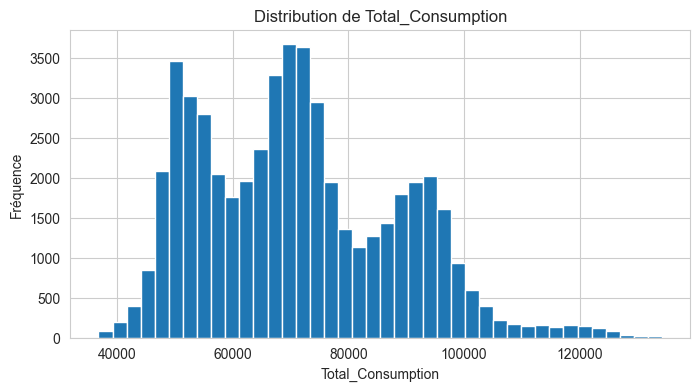

In [11]:
# Distribution de la consommation totale
plt.figure(figsize=(8,4))
plt.hist(df['Total_Consumption'], bins=40)
plt.title("Distribution de Total_Consumption")
plt.xlabel("Total_Consumption")
plt.ylabel("Fréquence")
plt.show()


Interprétation :
La distribution de la consommation totale montre que la majorité des valeurs se situe dans une plage intermédiaire, avec quelques valeurs plus élevées moins fréquentes. La forme étalée de l’histogramme indique une variabilité importante de la consommation, ce qui justifie l’utilisation d’un modèle capable de gérer différentes situations de demande.

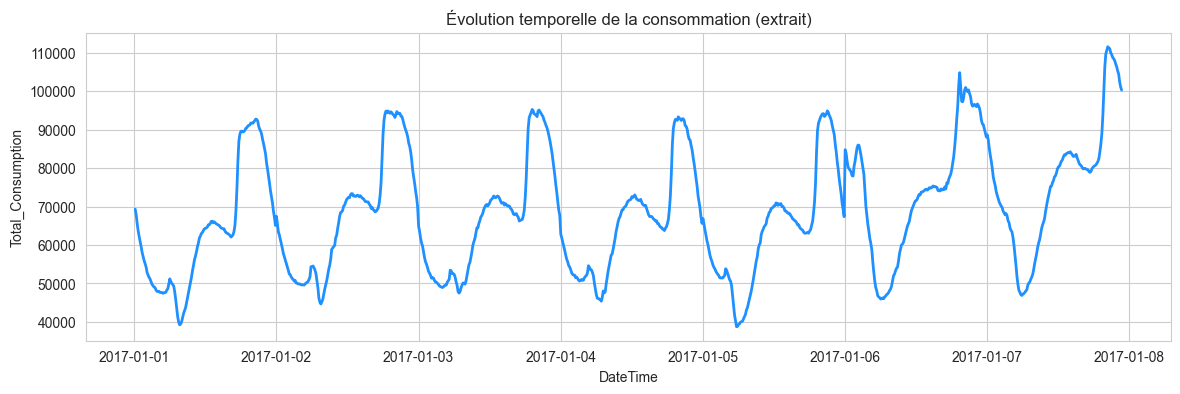

In [ ]:
# Évolution temporelle
plt.figure(figsize=(14,4))
plt.plot(
    df['DateTime'].iloc[:1000],
    df['Total_Consumption'].iloc[:1000],
    color='dodgerblue',
    linewidth=2
)

plt.title("Évolution temporelle de la consommation (extrait)")
plt.xlabel("DateTime")
plt.ylabel("Total_Consumption")
plt.grid(True)
plt.show()


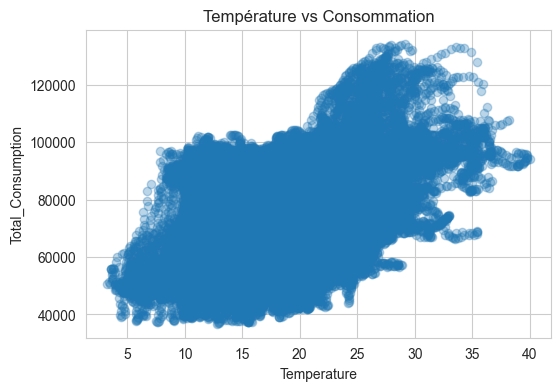

In [13]:
# Relations simples entre variables météo et consommation
plt.figure(figsize=(6,4))
plt.scatter(df['Temperature'], df['Total_Consumption'], alpha=0.3)
plt.title("Température vs Consommation")
plt.xlabel("Temperature")
plt.ylabel("Total_Consumption")
plt.show()


Interprétation :
Le graphique montre une relation globale positive entre la température et la consommation totale d’énergie : lorsque la température augmente, la consommation tend également à augmenter. Cependant, la dispersion des points indique que cette relation n’est pas strictement linéaire et que d’autres facteurs influencent aussi la consommation.

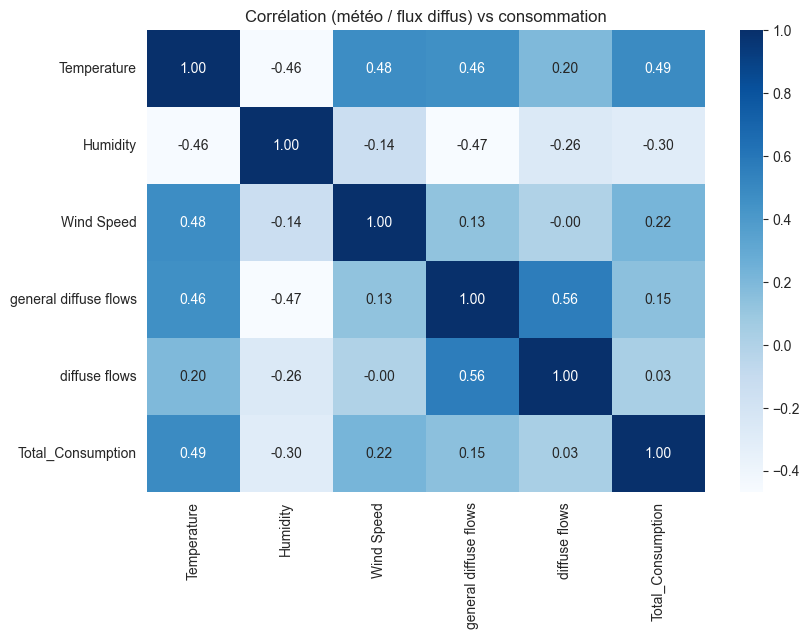

In [14]:
# Matrice de corrélation
corr_cols = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Total_Consumption']
plt.figure(figsize=(9,6))
sns.heatmap(df[corr_cols].corr(), annot=True, fmt=".2f", cmap="Blues")
plt.title("Corrélation (météo / flux diffus) vs consommation")
plt.show()


La consommation totale est positivement corrélée avec la température (≈ 0,49), ce qui signifie que la consommation tend à augmenter lorsque la température augmente.
L’humidité présente une corrélation négative modérée avec la consommation (≈ −0,30).
La vitesse du vent et les flux diffus ont une influence faible sur la consommation.
Globalement, la température est la variable météorologique la plus influente sur la consommation.

In [15]:
#  Transformations Mathématiques (Cycliques et Non-linéaires)
# Pour que le modèle comprenne que 23h est proche de 00h
df['Hour_Sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_Cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

In [16]:
# LA CLÉ : LE LAG (Consommation t-1) 
# On décale la colonne de consommation d'une ligne vers le bas
df['Total_Lag1'] = df['Total_Consumption'].shift(1)

In [17]:
# Le shift crée une valeur NaN à la première ligne, on la supprime
df.dropna(inplace=True)

In [18]:
# Conversion des colonnes numériques
cols_to_numeric = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Feature Engineering terminé (Lag créé).")
df[['DateTime', 'Total_Consumption', 'Total_Lag1']].head()

Feature Engineering terminé (Lag créé).


,DateTime,Total_Consumption,Total_Lag1
1,2017-01-01 00:10:00,69320.84387,70425.53544
2,2017-01-01 00:20:00,67803.22193,69320.84387
3,2017-01-01 00:30:00,65489.23209,67803.22193
4,2017-01-01 00:40:00,63650.44627,65489.23209
5,2017-01-01 00:50:00,62171.34398,63650.44627


In [19]:
# Sélection des features
features = [
    'Total_Lag1', 
    'Temperature', 'Temp_Squared', 'Humidity', 'Wind Speed', 
    'general diffuse flows', 'diffuse flows', 
    'Hour', 'Month', 'DayOfWeek', 'Year',
    'Hour_Sin', 'Hour_Cos'
]

X = df[features]
y = df['Total_Consumption']



In [20]:
# Séparer les données en ensemble d’entraînement et de test
# shuffle=False pour respecter l’ordre temporel des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Dimensions Train : {X_train.shape}")
print(f"Dimensions Test  : {X_test.shape}")

Dimensions Train : (41932, 13)
Dimensions Test  : (10483, 13)


## 4. Baseline (référence) : prédire `Total_Consumption(t)` par `Total_Lag1(t)`

Avant d'évaluer un modèle ML, on compare toujours à une règle simple (baseline).
Ici, une baseline naturelle est : **prédire la consommation actuelle par la consommation précédente**.


In [21]:
# Baseline : y_pred_baseline = Total_Lag1 (sur la partie test)
y_pred_baseline = X_test['Total_Lag1'].values

mae_base = mean_absolute_error(y_test, y_pred_baseline)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_base = r2_score(y_test, y_pred_baseline)

print("Baseline (Lag1) -> MAE :", round(mae_base, 3))
print("Baseline (Lag1) -> RMSE:", round(rmse_base, 3))
print("Baseline (Lag1) -> R²  :", round(r2_base, 3))


Baseline (Lag1) -> MAE : 836.799
Baseline (Lag1) -> RMSE: 1332.289
Baseline (Lag1) -> R²  : 0.993


## 5. Entraînement

In [22]:
print("Entraînement de la Régression Linéaire avec Lag...")

model = LinearRegression()
model.fit(X_train, y_train)

Entraînement de la Régression Linéaire avec Lag...


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [23]:
# Prédictions
y_pred = model.predict(X_test)


In [24]:
# Scores
r2 = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Performance R² : {r2:.4f}")
print(f"Erreur Moyenne Absolue (MAE) : {mae:.2f} MW")
print(f"Erreur Quadratique Moyenne (RMSE) : {rmse:.2f} MW")


Performance R² : 0.9941
Erreur Moyenne Absolue (MAE) : 736.85 MW
Erreur Quadratique Moyenne (RMSE) : 1183.61 MW


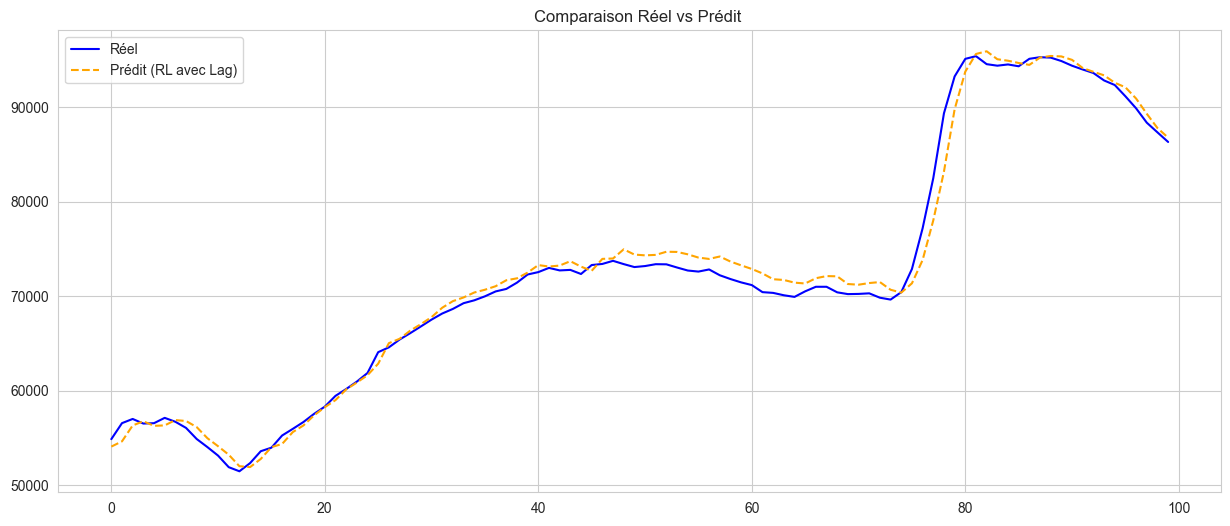

In [30]:
#Ce graphique visualise la qualité des prédictions (réelles vs prédites)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Réel', color='blue')
plt.plot(y_pred[:100], label='Prédit (RL avec Lag)', color='orange', linestyle='--')
plt.title("Comparaison Réel vs Prédit ")
plt.legend()
plt.show()

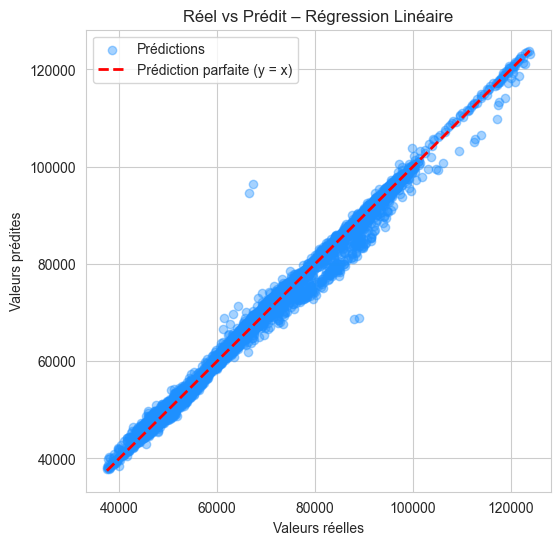

In [ ]:
# Graphe : nuage de points (Réel vs Prédit)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='dodgerblue', alpha=0.4, label='Prédictions')
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val],
         color='red', linestyle='--', linewidth=2,
         label='Prédiction parfaite (y = x)')

plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Réel vs Prédit – Régression Linéaire')
plt.legend()
plt.grid(True)
plt.show()


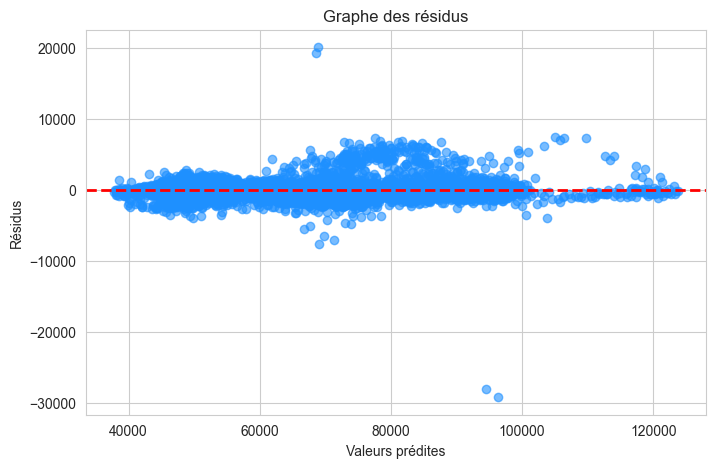

In [32]:
# Calcul des résidus
residuals = y_test - y_pred

# Graphe des résidus
plt.figure(figsize=(8,5))
plt.scatter(
    y_pred, residuals,
    color='dodgerblue',
    alpha=0.6
)

plt.axhline(
    0,
    color='red',
    linestyle='--',
    linewidth=2
)

plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Graphe des résidus")
plt.grid(True)
plt.show()


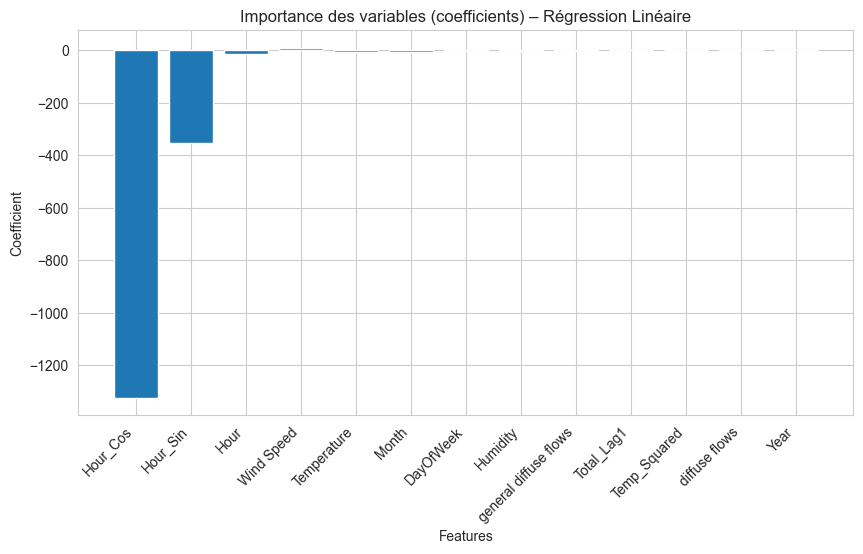

In [ ]:

# Coefficients du modèle
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values("Coefficient", key=abs, ascending=False)

plt.figure(figsize=(10,5))
plt.bar(coef_df["Feature"], coef_df["Coefficient"])
plt.xticks(rotation=45, ha="right")
plt.title("Importance des variables (coefficients) – Régression Linéaire")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()


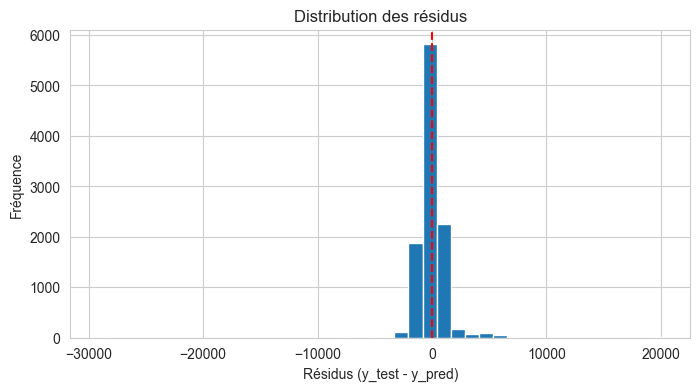

In [ ]:

residuals = y_test - y_pred

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=40)
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution des résidus")
plt.xlabel("Résidus (y_test - y_pred)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()


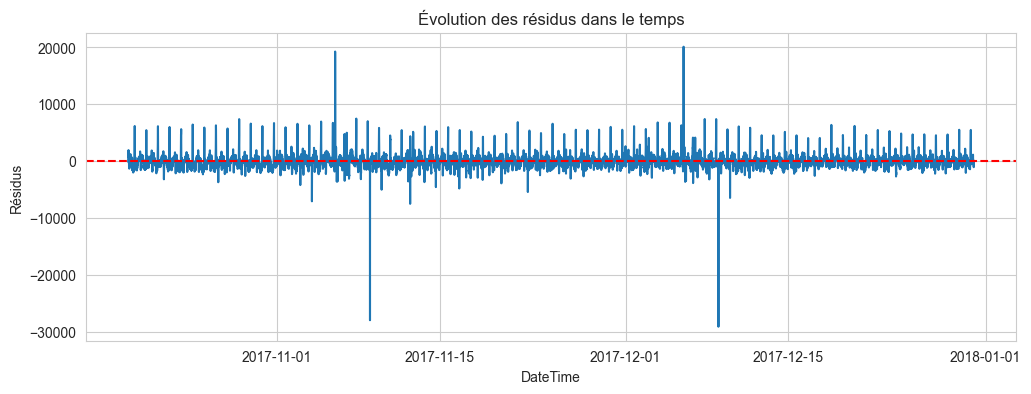

In [ ]:
time_test = df.loc[X_test.index, "DateTime"]

plt.figure(figsize=(12,4))
plt.plot(time_test, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title("Évolution des résidus dans le temps")
plt.xlabel("DateTime")
plt.ylabel("Résidus")
plt.grid(True)
plt.show()


## 6. Sauvegarde du modele

In [28]:
# Sauvegarde 
joblib.dump(model, 'modele_regression_lineaire.pkl')
joblib.dump(features, 'model_columns_regression.pkl')

print(" Modèle sauvegardé sous : 'modele_regression_lineaire.pkl'")
print(" Colonnes sauvegardées sous : 'model_columns_regression.pkl'")

 Modèle sauvegardé sous : 'modele_regression_lineaire.pkl'
 Colonnes sauvegardées sous : 'model_columns_regression.pkl'


## 7. Test : rechargement du modèle

In [29]:
loaded_model = joblib.load("modele_regression_lineaire.pkl")
loaded_cols = joblib.load("model_columns_regression.pkl")

print('Colonnes rechargées :', loaded_cols)

# Exemple de prédiction avec la première ligne de X_test
sample = X_test.iloc[[0]]
print('Valeur réelle  :', y_test.iloc[0])
print('Valeur prédite :', loaded_model.predict(sample)[0])

Colonnes rechargées : ['Total_Lag1', 'Temperature', 'Temp_Squared', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Hour', 'Month', 'DayOfWeek', 'Year', 'Hour_Sin', 'Hour_Cos']
Valeur réelle  : 54869.00826
Valeur prédite : 54079.22096946954
